# Preprocessing images and merged masks

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Importing librairies
import tensorflow as tf
import os
import random
import numpy as np
import cv2
from tqdm import tqdm 
from PIL import Image

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

In [3]:
# Initilizing X_train which contains original training images 

X_train = [] 

In [5]:
# Reading 4 images from the training set to test the preprocessing

image_directory = '/content/drive/MyDrive/Officiel/Training set/'
images = os.listdir(image_directory)
images.sort()
for image_name in tqdm(images[:4]):
    image = cv2.imread(image_directory+image_name)
    image = Image.fromarray(image)
    #print(image_name)
    X_train.append(np.array(image))


100%|██████████| 4/4 [00:00<00:00,  4.44it/s]


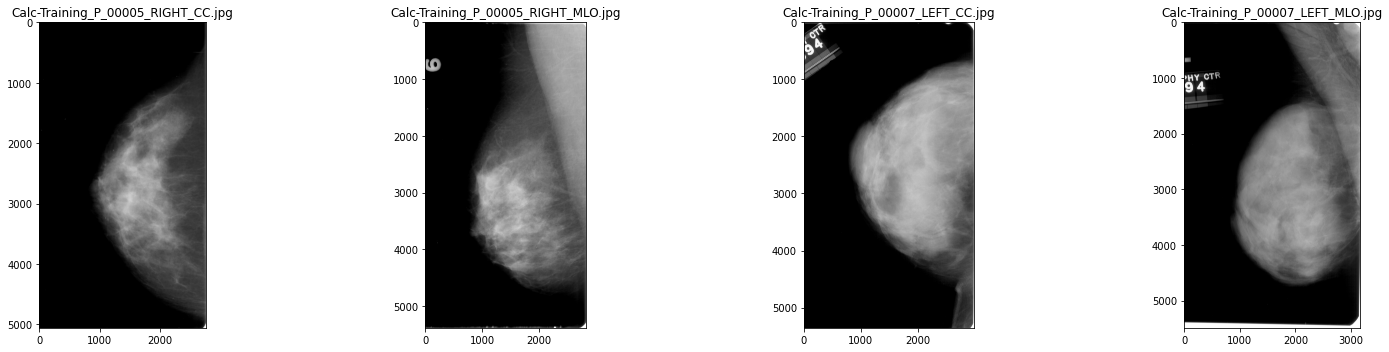

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=len(images[:4]), figsize = (22, 5))

# Plot images

for i in range(len(images[:4])):
    ax[i].imshow(X_train[i], cmap="gray")
    ax[i].set_title(f"{images[i]}")
    
plt.tight_layout()

# Normalisation

In [7]:
def MinMaxNormalise(img):
    
    '''
    This function does min-max normalisation on
    the given image.
    
    Parameters
    ----------
    img : {numpy.ndarray}
        The image to normalise.
        
    Returns
    -------
    norm_img: {numpy.ndarray}
        The min-max normalised image.
    '''
    
    norm_img = (img - img.min()) / (img.max() - img.min())
    
    return norm_img

In [9]:
arr_norm = [MinMaxNormalise(a) for a in X_train[:4]]

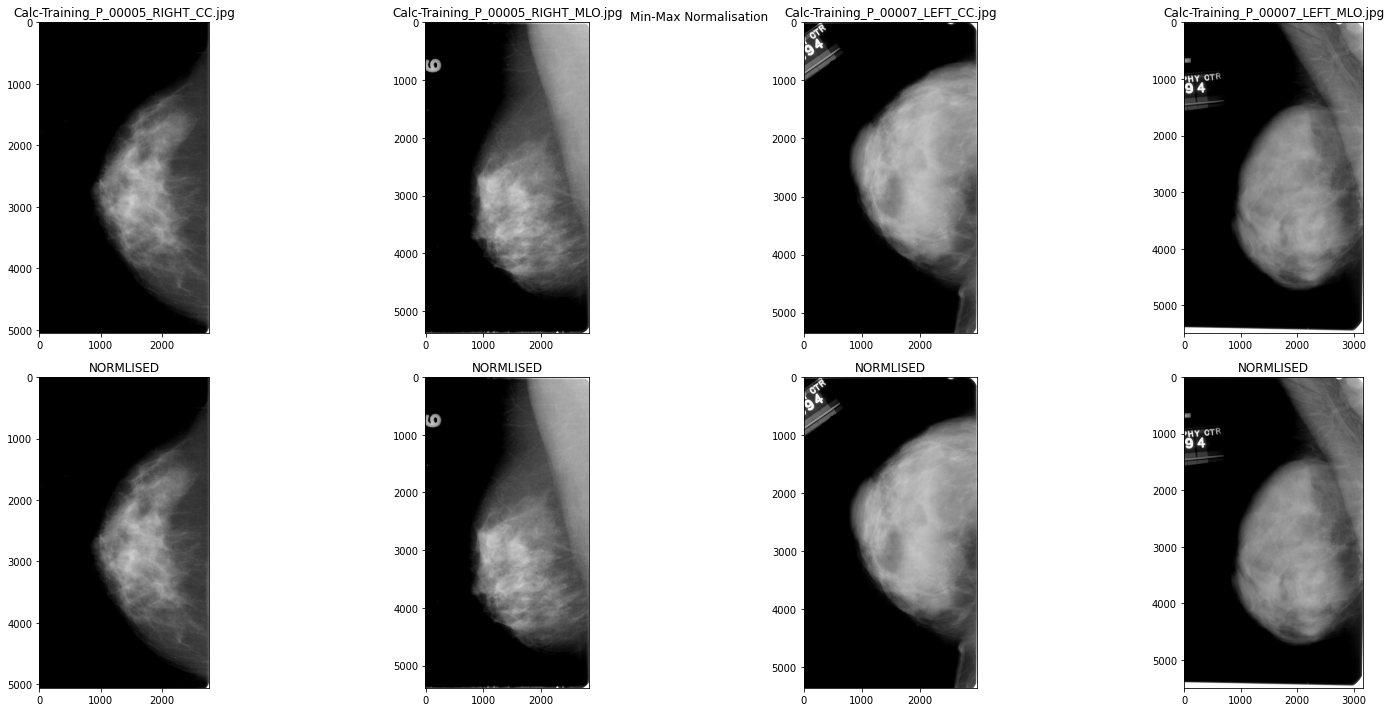

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=len(X_train[:4]), figsize = (22, 10))

fig.suptitle("Min-Max Normalisation")

# Plot original
for i in range(len(X_train[:4])):
    ax[0][i].imshow(X_train[i], cmap="gray")
    ax[0][i].set_title(f"{images[i]}")
    
# Plot normalised
for i in range(len(X_train[:4])):
    ax[1][i].imshow(arr_norm[i], cmap="gray")
    ax[1][i].set_title("NORMLISED")
    
plt.tight_layout()

# Crop borders 

In [11]:
def cropBorders(img, l=0.01, r=0.01, u=0.04, d=0.04):

    nrows = img.shape[0]
    ncols=img.shape[1]
    nchannels=img.shape[2]

    # Get the start and end rows and columns
    l_crop = int(ncols * l)
    r_crop = int(ncols * (1 - r))
    u_crop = int(nrows * u)
    d_crop = int(nrows * (1 - d))

    cropped_img = img[u_crop:d_crop, l_crop:r_crop]

    return cropped_img
        


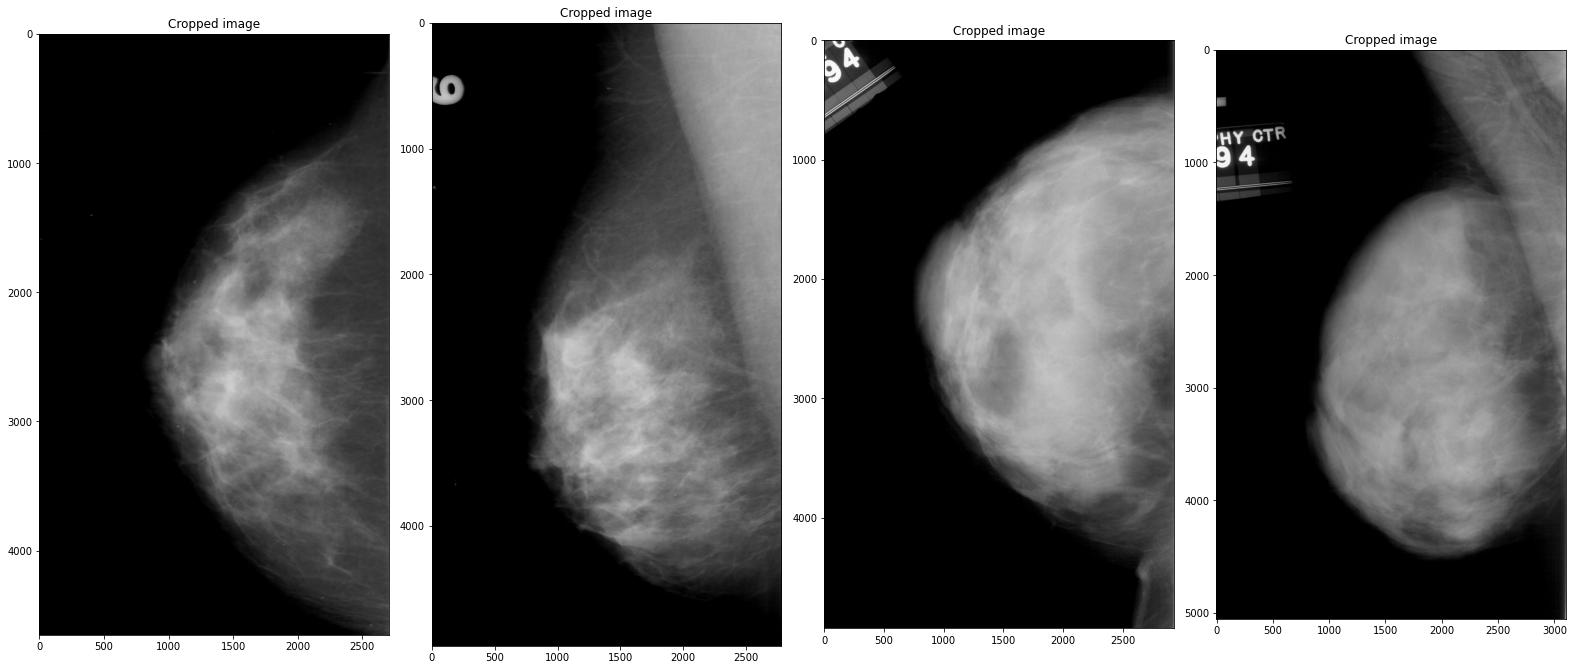

In [13]:
cropped_img_list = []

fig, ax = plt.subplots(nrows=1, ncols=len(X_train[:4]), figsize = (22, 10))

for i in range(len(X_train[:4])):
    
    # Plot original
    #ax[0][i].imshow(arr_norm[i], cmap="gray")
    #ax[0][i].set_title(f"{images[i]}")
    
    # Plot cropped
    cropped_img = cropBorders(arr_norm[i])
    cropped_img_list.append(cropped_img)
    ax[i].imshow(cropped_img, cmap="gray")
    ax[i].set_title("Cropped image")

    
plt.tight_layout()

# Removing artifacts from images ( by Generating masks )

In [14]:
def OwnGlobalBinarise(img, thresh, maxval):
    
    '''
    This function takes in a numpy array image and
    returns a corresponding mask that is a global
    binarisation on it based on a given threshold
    and maxval. Any elements in the array that is
    greater than or equals to the given threshold
    will be assigned maxval, else zero.
    
    Parameters
    ----------
    img : {numpy.ndarray}
        The image to perform binarisation on.
    thresh : {int or float}
        The global threshold for binarisation.
    maxval : {np.uint8}
        The value assigned to an element that is greater
        than or equals to `thresh`.
        
        
    Returns
    -------
    binarised_img : {numpy.ndarray, dtype=np.uint8}
        A binarised image of {0, 1}.
    '''
    
    binarised_img = np.zeros(img.shape, np.uint8)
    binarised_img[img >= thresh] = maxval
    
    return binarised_img

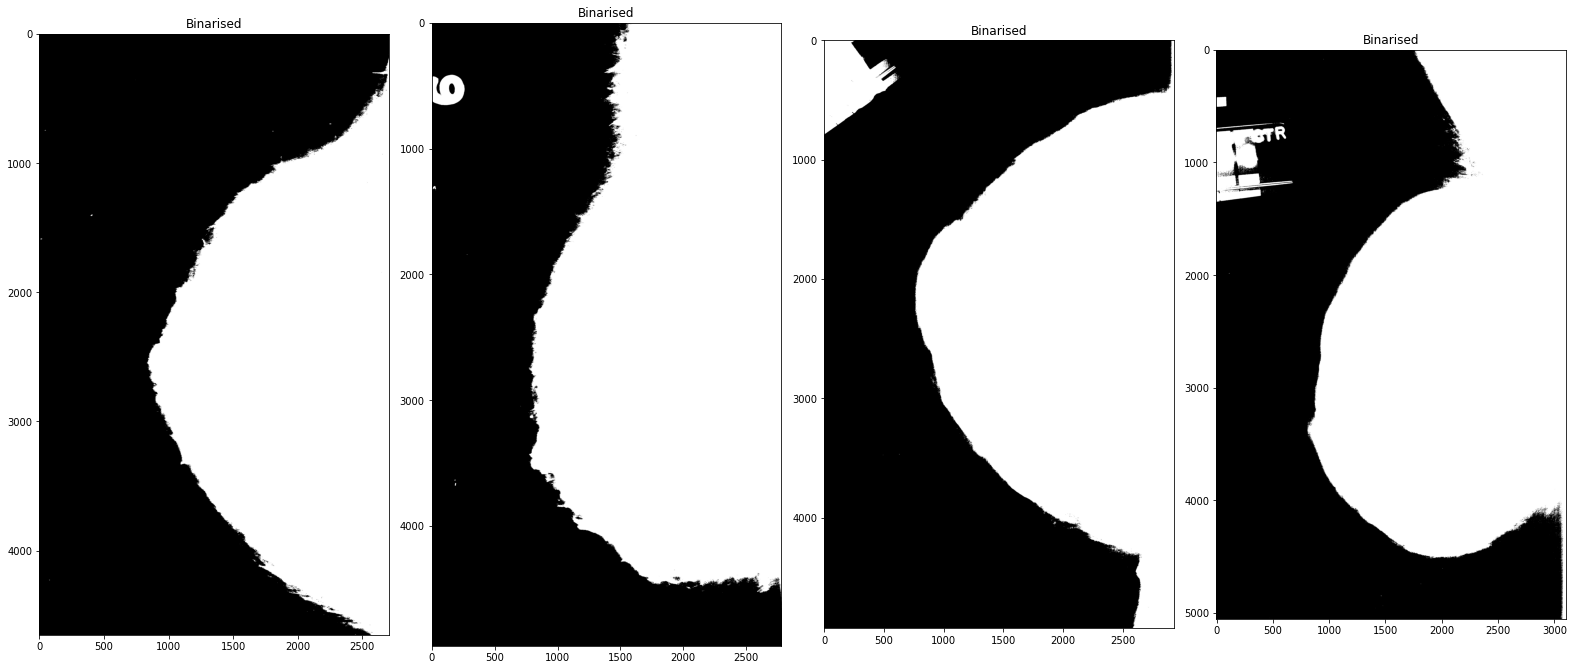

In [15]:
own_binarised_img_list = []

# Plot binarised images
fig, ax = plt.subplots(nrows=1, ncols=len(cropped_img_list), figsize=(22, 10))

for i in range(len(cropped_img_list)):
    
    # Plot original image.
    #ax[0][i].imshow(cropped_img_list[i], cmap="gray")
    #ax[0][i].set_title(f"{images[i]}")
    
    # Plot own binarised image.
    binarised_img = OwnGlobalBinarise(img=cropped_img_list[i], thresh=0.1, maxval=1.0)
    #print(binarised_img)
    own_binarised_img_list.append(binarised_img)
    ax[i].imshow(binarised_img*255, cmap="gray")
    ax[i].set_title("Binarised")
    
plt.tight_layout()

In [16]:
def OpenMask(mask, ksize=(23, 23), operation="open"):

    '''
    This function edits a given mask (binary image) by performing
    closing then opening morphological operations.
    
    Parameters
    ----------
    mask : {numpy.ndarray}
        The mask to edit.
        
    Returns
    -------
    edited_mask : {numpy.ndarray}
        The mask after performing close and open morphological
        operations.
    '''
        
    kernel = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=ksize)
    
    if operation == "open":
        edited_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    elif operation == "close":
        edited_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Then dilate
    edited_mask = cv2.morphologyEx(edited_mask, cv2.MORPH_DILATE, kernel)
    
    return edited_mask

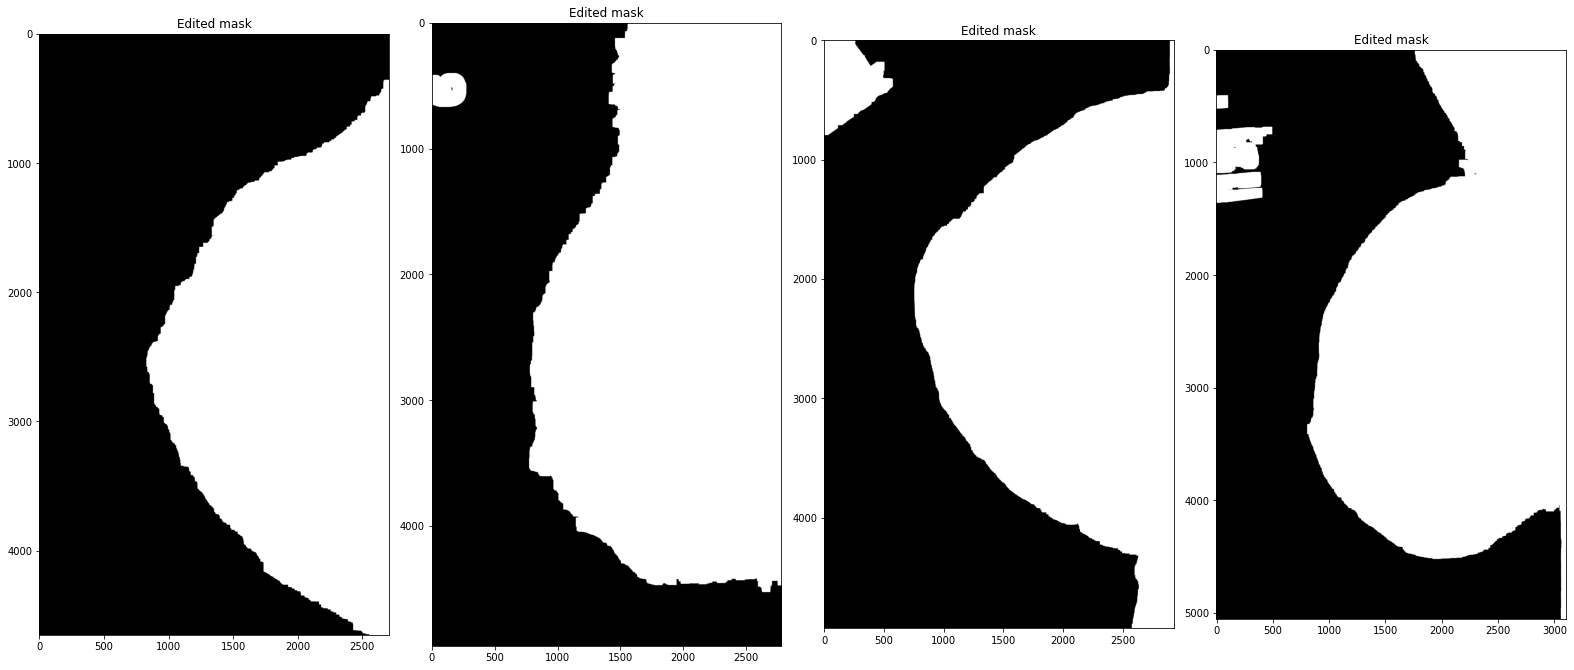

In [17]:
edited_mask_list = []

fig, ax = plt.subplots(nrows=1, ncols=len(arr_norm), figsize=(22, 10))

for i in range(len(arr_norm)):
    
    # Plot original image.
    #ax[0][i].imshow(cropped_img_list[i], cmap="gray")
    #ax[0][i].set_title(f"{images[i]}")
    
#     # Plot original mask.
#     ax[1][i].imshow(own_binarised_img_list[i], cmap="gray")
#     ax[1][i].set_title("Binarised")
    
    # Plot edited mask.
    edited_mask = OpenMask(mask=own_binarised_img_list[i], ksize=(33, 33), operation="open")
    edited_mask_list.append(edited_mask)
    ax[i].imshow(edited_mask*255, cmap="gray")
    ax[i].set_title("Edited mask")
    
plt.tight_layout()
#plt.savefig(fname="../data/raw_data/visualisations_for_slides/3_remove_noise/remove_noise.png", dpi=300)

In [18]:
def SortContoursByArea(contours, reverse=True):
    
    '''
    This function takes in list of contours, sorts them based
    on contour area, computes the bounding rectangle for each
    contour, and outputs the sorted contours and their
    corresponding bounding rectangles.
    
    Parameters
    ----------
    contours : {list}
        The list of contours to sort.
        
    Returns
    -------
    sorted_contours : {list}
        The list of contours sorted by contour area in descending
        order.
    bounding_boxes : {list}
        The list of bounding boxes ordered corresponding to the
        contours in `sorted_contours`.
    '''
    
    # Sort contours based on contour area.
    sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)
    
    # Construct the list of corresponding bounding boxes.
    bounding_boxes = [cv2.boundingRect(c) for c in sorted_contours]
    
    return sorted_contours, bounding_boxes

In [19]:
def XLargestBlobs(mask, top_X):
    
    '''
    This function finds contours in the given image and
    keeps only the top X largest ones.
    
    Parameters
    ----------
    mask : {numpy.ndarray, dtype=np.uint8}
        The mask to get the top X largest blobs.
    top_X : {int}
        The top X contours to keep based on contour area
        ranked in decesnding order.
        
        
    Returns
    -------
    n_contours : {int}
        The number of contours found in the given `mask`.
    X_largest_blobs : {numpy.ndarray}
        The corresponding mask of the image containing only
        the top X largest contours in white.
    '''
        
    # Find all contours from binarised image.
    # Note: parts of the image that you want to get should be white.
    contours, hierarchy = cv2.findContours(image=mask,
                                           mode=cv2.RETR_EXTERNAL,
                                           method=cv2.CHAIN_APPROX_NONE)
    
    n_contours = len(contours)
    
    # Only get largest blob if there is at least 1 contour.
    if n_contours > 0:
        
        # Make sure that the number of contours to keep is at most equal 
        # to the number of contours present in the mask.
        if n_contours < top_X or top_X == None:
            top_X = n_contours
        
        # Sort contours based on contour area.
        sorted_contours, bounding_boxes = SortContoursByArea(contours=contours,
                                                             reverse=True)
        
        # Get the top X largest contours.
        X_largest_contours = sorted_contours[0:top_X]
        
        # Create black canvas to draw contours on.
        to_draw_on = np.zeros(mask.shape, np.uint8)
        
        # Draw contours in X_largest_contours.
        X_largest_blobs = cv2.drawContours(image=to_draw_on, # Draw the contours on `to_draw_on`.
                                           contours=X_largest_contours, # List of contours to draw.
                                           contourIdx=-1, # Draw all contours in `contours`.
                                           color=1, # Draw the contours in white.
                                           thickness=-1) # Thickness of the contour lines.
        
    return n_contours, X_largest_blobs

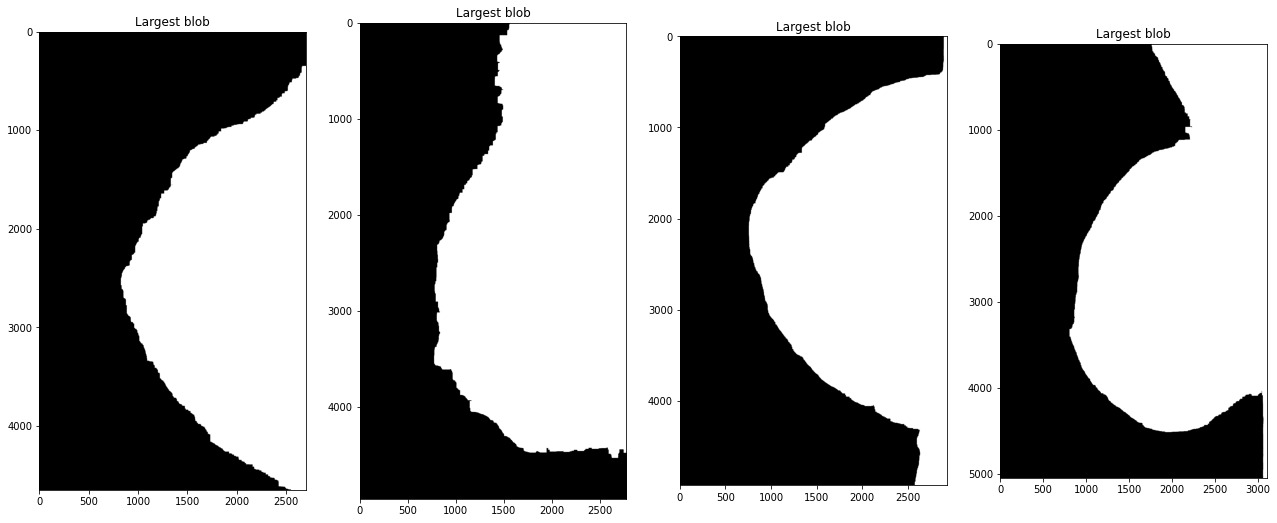

In [20]:
X_largest_blobs_list = []

fig, ax = plt.subplots(nrows=1, ncols=len(arr_norm), figsize=(22, 10))

for i in range(len(arr_norm)):
    
    # Plot original image.
    #ax[0][i].imshow(arr_norm[i], cmap="gray")
    #ax[0][i].set_title(f"{images[i]}")
    
#     # Plot original mask.
#     ax[1][i].imshow(own_binarised_img_list[i], cmap="gray")
#     ax[1][i].set_title("Binarised")
    
#     # Plot edited mask.
#     ax[2][i].imshow(edited_mask_list[i], cmap="gray")
#     ax[2][i].set_title("Edited masks")
    
    # Plot largest-blob mask.
    mask=edited_mask_list[i]
    gray = mask.copy() 
    gray = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
    _, X_largest_blobs = XLargestBlobs(gray, top_X=1)
    X_largest_blobs_list.append(X_largest_blobs)
    ax[i].imshow(X_largest_blobs, cmap="gray")
    ax[i].set_title("Largest blob")
    
#plt.tight_layout()
#plt.savefig(fname="../data/raw_data/visualisations_for_slides/4_largest_blob/largest_blob.png", dpi=300)

In [21]:
def InvertMask(mask):
    
    '''
    This function inverts a given mask (i.e. 0 -> 1
    and 1 -> 0).
    
    Parameters
    ----------
    mask : {numpy.ndarray, dtype=np.uint8}
        The mask to invert.
        
    Returns
    -------
    inverted_mask: {numpy.ndarray}
        The inverted mask.
    '''
    
    inverted_mask = np.zeros(mask.shape, np.uint8)
    inverted_mask[mask == 0] = 1
    
    return inverted_mask

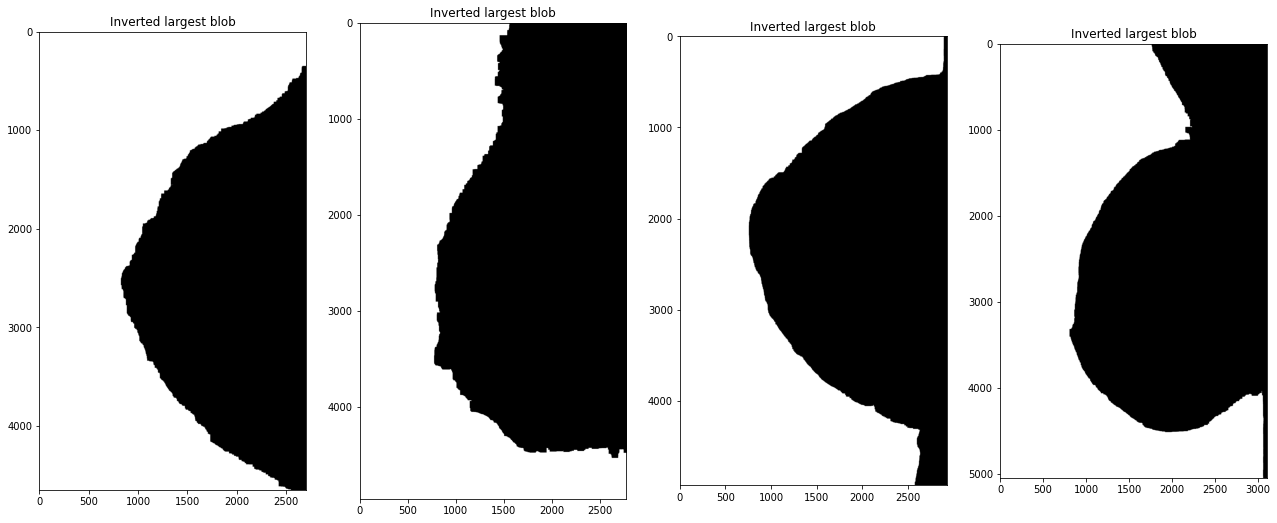

In [22]:
inverted_mask_list = []

fig, ax = plt.subplots(nrows=1, ncols=len(arr_norm), figsize=(22, 10))

for i in range(len(arr_norm)):
    
    # Plot original image.
    #ax[0][i].imshow(cropped_img_list[i], cmap="gray")
    #ax[0][i].set_title(f"{images[i]}")
    
#     # Plot original mask.
#     ax[1][i].imshow(binarised_img_list[i], cmap="gray")
#     ax[1][i].set_title("Binarised")
    
#     # Plot edited mask.
#     ax[2][i].imshow(edited_mask_list[i], cmap="gray")
#     ax[2][i].set_title("Edited masks")
    
#     # Plot largest-blob mask.
#     ax[3][i].imshow(X_largest_blobs_list[i], cmap="gray")
#     ax[3][i].set_title("Largest blob")
    
    # Plot inverted largest-blob mask
    inverted_mask = InvertMask(X_largest_blobs_list[i])
    inverted_mask_list.append(inverted_mask)
    ax[i].imshow(inverted_mask, cmap="gray")
    ax[i].set_title("Inverted largest blob")
    
#plt.tight_layout()
#plt.savefig(fname="../data/raw_data/visualisations_for_slides/5_inverted/inverted.png", dpi=300)

In [23]:
def ApplyMask(img, mask):
    
    '''
    This function applies a mask to a given image. White
    areas of the mask are kept, while black areas are
    removed.
    
    Parameters
    ----------
    img : {numpy.ndarray}
        The image to mask.
    mask : {numpy.ndarray, dtype=np.uint8}
        The mask to apply.
        
    Returns
    -------
    masked_img: {numpy.ndarray}
        The masked image.
    '''
    
    masked_img = img.copy()
    masked_img[mask == 0] = 0
    
    return masked_img

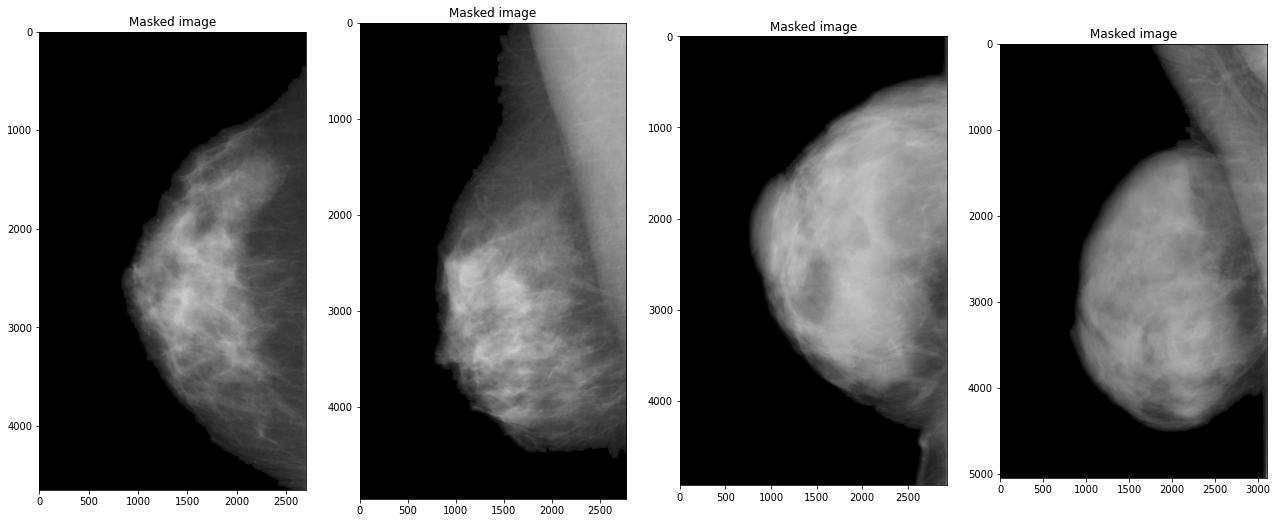

In [24]:
own_masked_img_list = []

fig, ax = plt.subplots(nrows=1, ncols=len(arr_norm), figsize=(22, 10))

for i in range(len(arr_norm)):
    
    # Plot original image.
    #ax[0][i].imshow(cropped_img_list[i], cmap="gray")
    #ax[0][i].set_title(f"{images[i]}")
    
#     # Plot original mask.
#     ax[1][i].imshow(binarised_img_list[i], cmap="gray")
#     ax[1][i].set_title("Binarised")
    
#     # Plot edited mask.
#     ax[2][i].imshow(edited_mask_list[i], cmap="gray")
#     ax[2][i].set_title("Edited masks")
    
#     # Plot largest-blob mask.
#     ax[3][i].imshow(X_largest_blobs_list[i], cmap="gray")
#     ax[3][i].set_title("Largest blob")
    
    # Plot applying largest-blob mask
    masked_img = ApplyMask(img=cropped_img_list[i], mask=X_largest_blobs_list[i])
    own_masked_img_list.append(masked_img)
    ax[i].imshow(masked_img, cmap="gray")
    ax[i].set_title("Masked image")

    
#plt.tight_layout()
#plt.savefig(fname="../data/raw_data/visualisations_for_slides/6_apply_mask/apply_mask.png", dpi=300)

# Horizontal Flip

In [25]:
def HorizontalFlip(mask):
    
    '''
    This function figures out how to flip (also entails whether
    or not to flip) a given mammogram and its mask. The correct
    orientation is the breast being on the left (i.e. facing
    right) and it being the right side up. i.e. When the
    mammogram is oriented correctly, the breast is expected to
    be found in the bottom left quadrant of the frame.
    
    Parameters
    ----------
    mask : {numpy.ndarray, dtype=np.uint8}
        The corresponding mask of the CC image to flip.

    Returns
    -------
    horizontal_flip : {boolean}
        True means need to flip horizontally,
        False means otherwise.
    '''
    
    # Get number of rows and columns in the image.
    nrows, ncols = mask.shape
    x_center = ncols // 2
    y_center = nrows // 2
    
    # Sum down each column.
    col_sum = mask.sum(axis=0)
    # Sum across each row.
    row_sum = mask.sum(axis=1)
    
    left_sum = sum(col_sum[0:x_center])
    right_sum = sum(col_sum[x_center:-1])
    top_sum = sum(row_sum[0:y_center])
    bottom_sum = sum(row_sum[y_center:-1])
    
    if left_sum < right_sum:
        horizontal_flip = True
    else:
        horizontal_flip = False
        
    return horizontal_flip

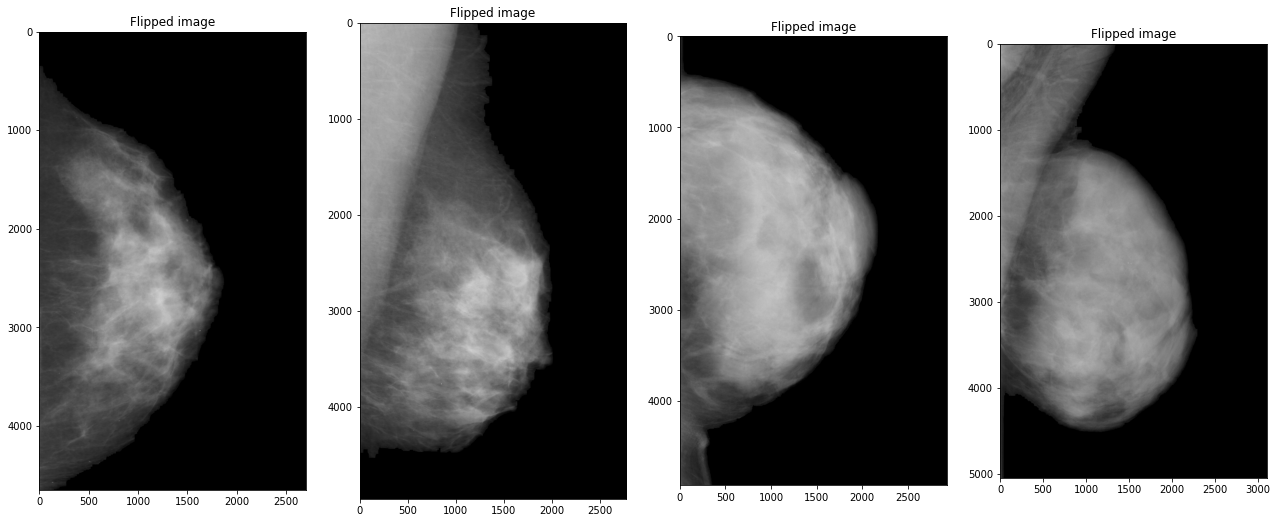

In [26]:
flipped_img_list = []
#print(X_largest_blobs_list)

fig, ax = plt.subplots(nrows=1, ncols=len(arr_norm), figsize=(22, 10))

for i in range(len(arr_norm)):
    
    # Plot original image.
    #ax[0][i].imshow(cropped_img_list[i], cmap="gray")
    #ax[0][i].set_title(f"{images[i]}")
    
#     # Plot largest-blob mask.
#     ax[1][i].imshow(X_largest_blobs_list[i], cmap="gray")
#     ax[1][i].set_title("Largest blob")
    
#     # Plot final image.
#     ax[2][i].imshow(final_result_1_list[i], cmap="gray")
#     ax[2][i].set_title("FINAL RESULT")
    
    # Plot flipped image.
   
    horizontal_flip = HorizontalFlip(mask=X_largest_blobs_list[i])
    if horizontal_flip:
        flipped_img = np.fliplr(own_masked_img_list[i])
        flipped_img_list.append(flipped_img)
    else:
        flipped_img_list.append(own_masked_img_list[i])
    
    ax[i].imshow(flipped_img_list[i], cmap="gray")
    ax[i].set_title("Flipped image")

#plt.tight_layout()

# Enhancement 

In [27]:
def clahe(img, clip=2.0, tile=(8, 8)):
    
    '''
    This function applies the Contrast-Limited Adaptive
    Histogram Equalisation filter to a given image.
    
    Parameters
    ----------
    img : {numpy.ndarray}
        The image to edit.
    clip : {int or floa}
        Threshold for contrast limiting.
    tile : {tuple (int, int)}
        Size of grid for histogram equalization. Input
        image will be divided into equally sized
        rectangular tiles. `tile` defines the number of
        tiles in row and column.
    
    Returns
    -------
    clahe_img : {numpy.ndarray}
        The edited image.
    '''
    
    # Convert to uint8.
    # img = skimage.img_as_ubyte(img)
    img = cv2.normalize(
        img,
        None,
        alpha=0,
        beta=255,
        norm_type=cv2.NORM_MINMAX,
        dtype=cv2.CV_32F,
    )
    img_uint8 = img.astype("uint8")
    
    clahe_create = cv2.createCLAHE(clipLimit=clip, tileGridSize=tile)
    gray_image = cv2.cvtColor(img_uint8, cv2.COLOR_BGR2GRAY)
    
    clahe_img = clahe_create.apply(gray_image)

    return clahe_img

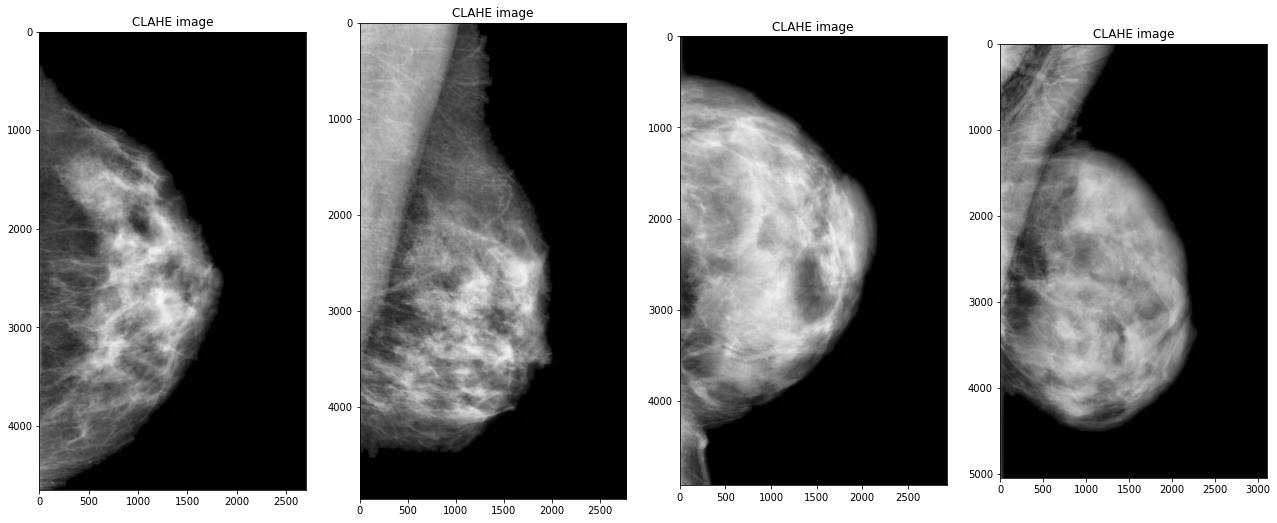

In [28]:
clahe_img_list = []

fig, ax = plt.subplots(nrows=1, ncols=len(arr_norm), figsize=(22, 10))

for i in range(len(arr_norm)):
    
    # Plot original image.
    #ax[0][i].imshow(flipped_img_list[i], cmap="gray")
    #ax[0][i].set_title(f"{images[i]}")
    
#     # Plot largest-blob mask.
#     ax[1][i].imshow(X_largest_blobs_list[i], cmap="gray")
#     ax[1][i].set_title("Largest blob")
    
#     # Plot final image.
#     ax[2][i].imshow(final_result_1_list[i], cmap="gray")
#     ax[2][i].set_title("FINAL RESULT")
    
    # CLAHE enhancement.
    clahe_img = clahe(img=flipped_img_list[i])
    clahe_img_list.append(clahe_img)
    
    ax[i].imshow(clahe_img_list[i], cmap="gray")
    ax[i].set_title("CLAHE image")

#plt.tight_layout()
#plt.savefig(fname="../data/raw_data/visualisations_for_slides/8_clahe/clahe.png", dpi=300)

# Change to square 

In [29]:
def Pad(img):
    
    '''
    This function pads a given image with black pixels,
    along its shorter side, into a square and returns
    the square image.
    
    If the image is portrait, black pixels will be
    padded on the right to form a square.
    
    If the image is landscape, black pixels will be
    padded on the bottom to form a square.
    
    Parameters
    ----------
    img : {numpy.ndarray}
        The image to pad.

    Returns
    -------
    padded_img : {numpy.ndarray}
        The padded square image, if padding was required
        and done.
    img : {numpy.ndarray}
        The original image, if no padding was required.
    '''
    
    nrows, ncols = img.shape
    
    # If padding is required...
    if nrows != ncols:
        
        # Take the longer side as the target shape.    
        if ncols < nrows:
            target_shape = (nrows, nrows)
        elif nrows < ncols:
            target_shape = (ncols, ncols)
        
        # Pad.
        padded_img = np.zeros(shape=target_shape)
        padded_img[ :nrows, :ncols ] = img
        
        return padded_img
    
    # If padding is not required, return original image.
    elif nrows == ncols:
        
        return img

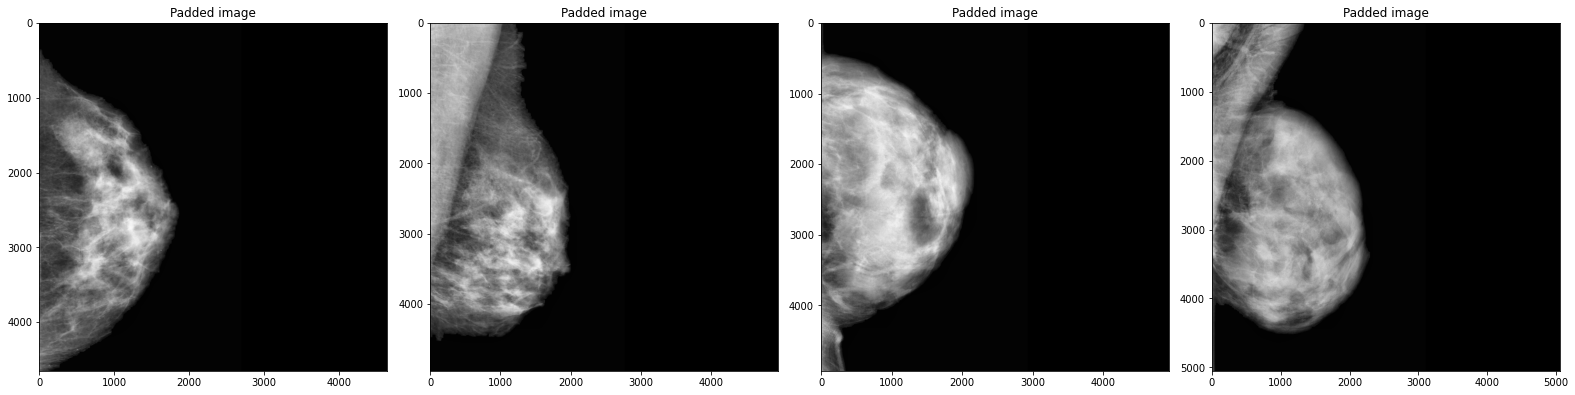

In [30]:
padded_img_list = []

fig, ax = plt.subplots(nrows=1, ncols=len(arr_norm), figsize=(22, 10))

for i in range(len(arr_norm)):
    
    # Plot original image.
    #ax[0][i].imshow(cropped_img_list[i], cmap="gray")
    #ax[0][i].set_title(f"{images[i]}")
    
#     # Plot flipped image.
#     ax[1][i].imshow(flipped_img_list[i], cmap="gray")
#     ax[1][i].set_title("Flipped image")
    
    # Plot padded image.
    padded_img = Pad(img=clahe_img_list[i])
    padded_img_list.append(padded_img)
    ax[i].imshow(padded_img, cmap="gray")
    ax[i].set_title("Padded image")

plt.tight_layout()

# Preprocessing all images using the functions that we defined above

In [35]:
def fullMammoPreprocess(img):
    

    # Step 1: Initial crop.
    cropped_img = cropBorders(img=img, l=0.01, r=0.01, u=0.04, d=0.04)
    
    # Step 2: Min-max normalise.
    norm_img = MinMaxNormalise(img=cropped_img)
    

    # Step 3: Remove artefacts.
    binarised_img = OwnGlobalBinarise(img=norm_img, thresh=0.1, maxval=1.0)
    edited_mask = OpenMask(mask=binarised_img, ksize=(23, 23), operation="open" )
    mask=edited_mask
    gray = mask.copy() 
    gray = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
    _, xlargest_mask = XLargestBlobs(gray, top_X=1)

    masked_img = ApplyMask(img=norm_img, mask=xlargest_mask)
    
    
    
    # Step 4: Horizontal flip.
    lr_flip = HorizontalFlip(mask=xlargest_mask)
    if lr_flip:
        flipped_img = np.fliplr(masked_img)
    elif not lr_flip:
        flipped_img = masked_img
        
    
    
    # Step 5: CLAHE enhancement.
    clahe_img = clahe(img=flipped_img)
    
    

    # Step 6: pad.
    padded_img = Pad(img=clahe_img)
    padded_img = cv2.normalize(
        padded_img,
        None,
        alpha=0,
        beta=255,
        norm_type=cv2.NORM_MINMAX,
        dtype=cv2.CV_32F,
    )
   
    
    # Step 7: Min-max normalise.
    img_pre = MinMaxNormalise(img=padded_img)
    

    return img_pre, lr_flip


# Preprocessing all merged masks using the functions that we defined above

In [36]:
def maskPreprocess(mask, lr_flip):
    
    # Step 1: Initial crop.
    mask = cropBorders(mask,l=0.01, r=0.01, u=0.04, d=0.04)
    
    
    # Step 2: Horizontal flip.
    if lr_flip:
        flipped_img = np.fliplr(mask)
    else:
        flipped_img = mask
    
    
    
    gray_image = cv2.cvtColor(flipped_img, cv2.COLOR_BGR2GRAY)
    
 

    # Step 3: Pad.
    padded_img = Pad(img=gray_image)
    mask_pre= MinMaxNormalise(img=padded_img)

    return mask_pre

In [45]:
import PIL

Y_train = [] 
mask_directory = '/content/drive/MyDrive/Officiel/merged_masks_training/Full_masks_training'
masks = os.listdir(mask_directory)
masks.sort()
fixed_height = 1024

for image_name in tqdm(masks[:4]):
  path=os.path.join(mask_directory,image_name)
  image = cv2.imread(path)[:,:,:3]
  image = Image.fromarray(image)
  height_percent = (fixed_height / float(image.size[1]))
  width_size = int((float(image.size[0]) * float(height_percent)))
  image = image.resize((width_size, fixed_height), PIL.Image.NEAREST)
  Y_train.append(np.array(image))


100%|██████████| 4/4 [00:00<00:00, 70.30it/s]


In [46]:
img_preprocessed = []
mask_preprocessed = []

In [47]:
for i in tqdm(range(len(X_train[:4]))) :
  img_pre, lr_flip= fullMammoPreprocess(X_train[i])
  img_preprocessed.append(img_pre)

  mask_pre= maskPreprocess(Y_train[i], lr_flip)
  mask_preprocessed.append(mask_pre)


100%|██████████| 4/4 [00:06<00:00,  1.58s/it]


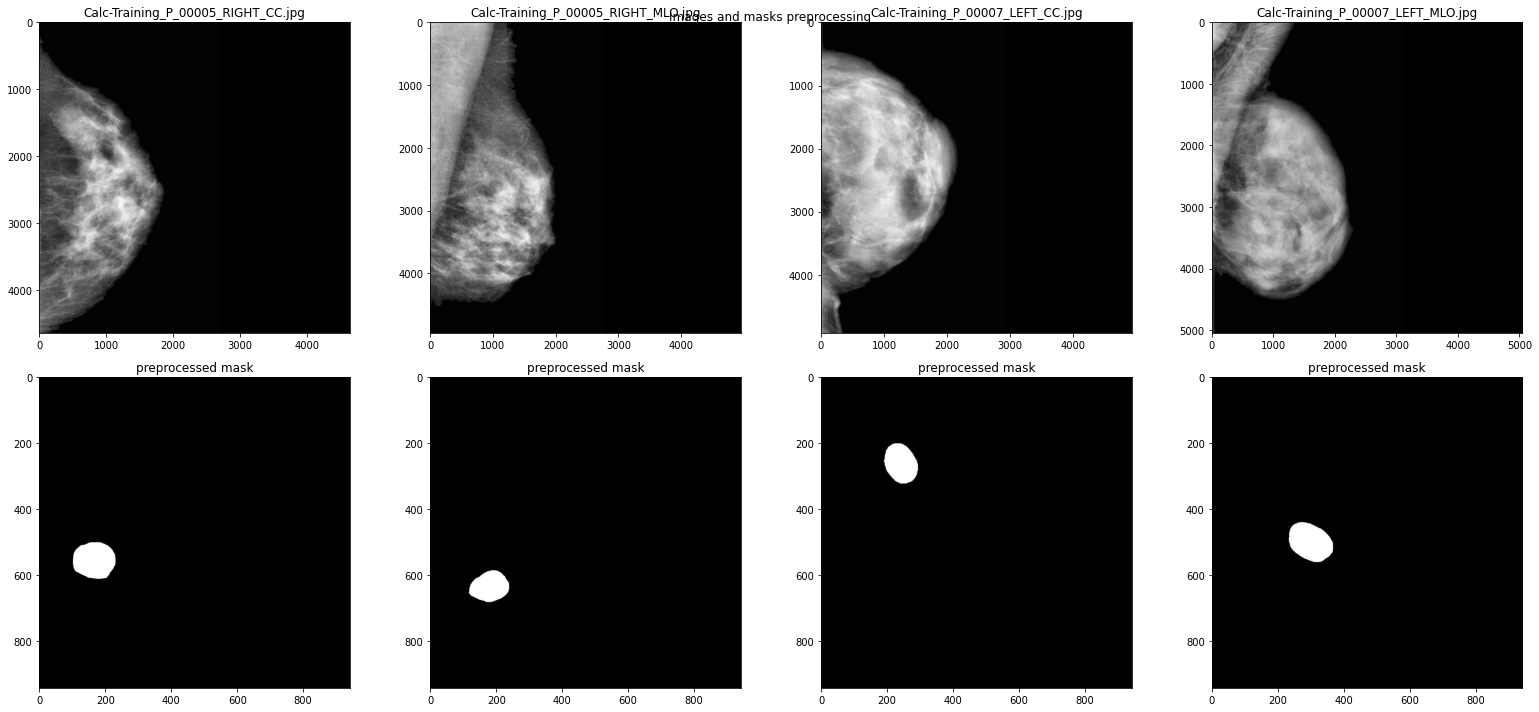

In [50]:
fig, ax = plt.subplots(nrows=2, ncols=len(img_preprocessed[:4]), figsize = (22, 10))

fig.suptitle("Images and masks preprocessing")

# Plot original
for i in range(len(img_pre[:4])):
    ax[0][i].imshow(img_preprocessed[i], cmap="gray")
    ax[0][i].set_title(f"{images[i]}")
    
# Plot normalised
for i in range(len(mask_preprocessed[:4])):
    ax[1][i].imshow(mask_preprocessed[i], cmap="gray")
    ax[1][i].set_title("preprocessed mask")
    
plt.tight_layout()